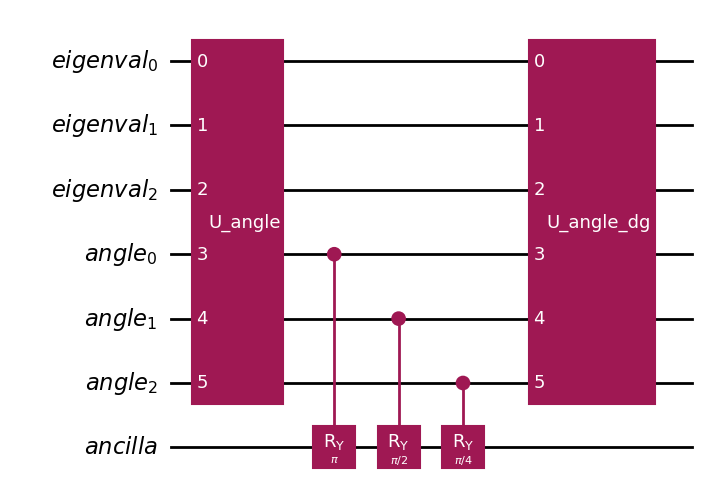

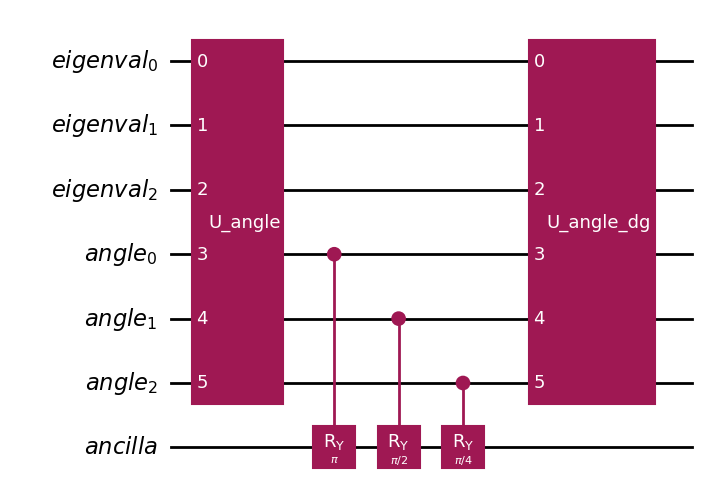

In [45]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RYGate
from numpy import pi

def construct_u_angle(d):
    """
    Placeholder for U_angle.
    In a real circuit, this should map |0^{d'-d}> |lambda_j> to |\tilde{\theta}_j>,
    i.e., compute theta_j = arcsin(C/lambda_j), here we simply copy for demonstration.
    """
    qc = QuantumCircuit(2*d, name="U_angle")
    for i in range(d):
        qc.cx(i, d+i)  # eigenval[i] -> angle[i]
    return qc.to_gate()

def controlled_rotation_subcircuit(d, C_over_lambda_angles):
    """
    Constructs the entire controlled rotation structure of HHL as in Figure 4.2:
    - |0> (ancilla)
    - |0^{d'-d}> (here, omitted for simplicity)
    - |lambda_j> (eigenvalue register)
    
    Steps:
    1. U_angle maps |0>|lambda_j> → |\tilde{theta}_j>
    2. U_theta controlled rotation with angle theta_j
    3. U_angle† uncomputes angle register
    """
    # Quantum Registers
    eigenval = QuantumRegister(d, 'eigenval')
    angle = QuantumRegister(d, 'angle')
    ancilla = QuantumRegister(1, 'ancilla')
    qc = QuantumCircuit(eigenval, angle, ancilla, name="ctrl_rot")
    
    # STEP 1: U_angle
    U_angle_gate = construct_u_angle(d)
    qc.append(U_angle_gate, eigenval[:] + angle[:])
    
    # STEP 2: Controlled-RY by angle
    for i in range(d):
        theta = C_over_lambda_angles[i] if C_over_lambda_angles else pi/(2**i)
        ry = RYGate(2*theta).control()
        qc.append(ry, [angle[i], ancilla[0]])
    
    # STEP 3: U_angle†
    qc.append(U_angle_gate.inverse(), eigenval[:] + angle[:])
    return qc

# Example (for d=3)
d = 3
# For a proper derivation, C_over_lambda_angles should be computed from the eigenvalues λ_j.
# Here, just as a demonstration, we'll provide fixed angles. You'd map binary-encoded λ_j to θ_j in real code.
C_over_lambda_angles = [pi/2, pi/4, pi/8]

# Build the subcircuit for the controlled rotation block (Figure 4.2)
subcircuit = controlled_rotation_subcircuit(d, C_over_lambda_angles)
subcircuit.draw('mpl')


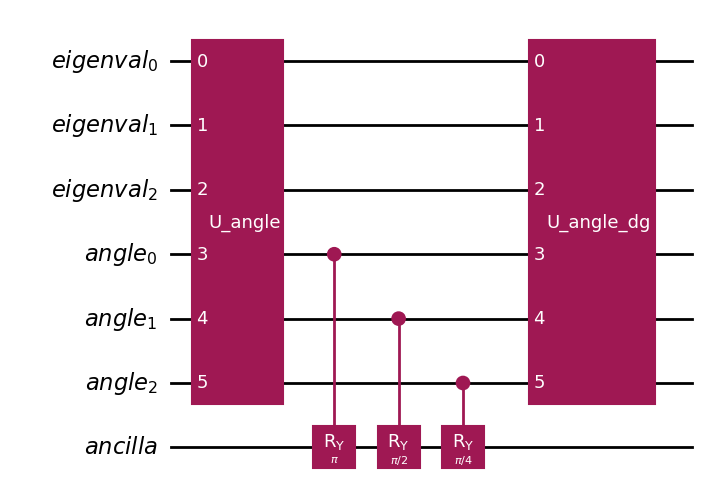

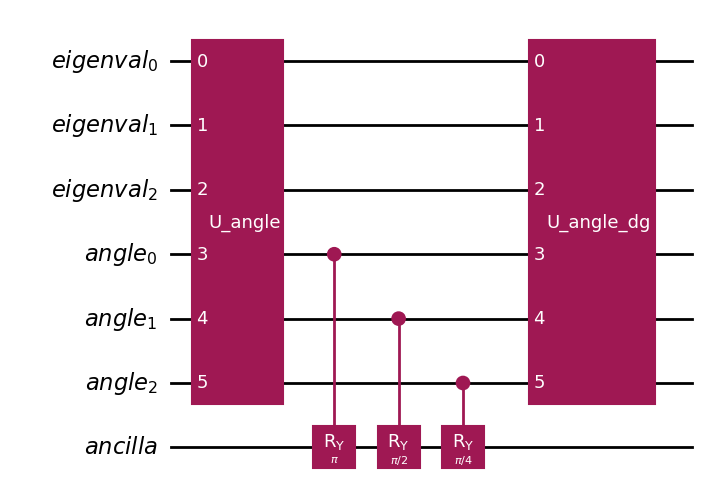

In [46]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RYGate
from numpy import pi

def construct_u_angle(d):
    """
    Placeholder U_angle gate. In a real HHL, this computes theta_j = arcsin(C/lambda_j).
    Here, each eigenvalue qubit copies its value to the angle register.
    """
    qc = QuantumCircuit(2*d, name="U_angle")
    for i in range(d):
        qc.cx(i, d+i)
    return qc.to_gate()

def controlled_rotation_subcircuit(d, theta_angles=None):
    """
    Constructs Figure 4.2-like controlled rotation:
      eigenval (|lambda_j⟩), angle (|tilde_theta_j⟩), ancilla (|0⟩)
    """
    eigenval = QuantumRegister(d, 'eigenval')
    angle = QuantumRegister(d, 'angle')
    ancilla = QuantumRegister(1, 'ancilla')
    qc = QuantumCircuit(eigenval, angle, ancilla, name="CtrlRotSub")
    
    # Step 1: U_angle
    U_angle_gate = construct_u_angle(d)
    qc.append(U_angle_gate, eigenval[:] + angle[:])
    
    # Step 2: Controlled Ry
    if theta_angles is None:
        theta_angles = [pi/(2**i) for i in range(d)]
    for i in range(d):
        ry_gate = RYGate(2*theta_angles[i]).control(1)
        qc.append(ry_gate, [angle[i], ancilla[0]])
    
    # Step 3: U_angle†
    qc.append(U_angle_gate.inverse(), eigenval[:] + angle[:])
    return qc

# Example usage (for d=3 eigenvalue bits)
d = 3
theta_angles = [pi/2, pi/4, pi/8]  # For demonstration; set by your application
subcircuit = controlled_rotation_subcircuit(d, theta_angles)

# Draw the subcircuit (with matplotlib)
subcircuit.draw('mpl')


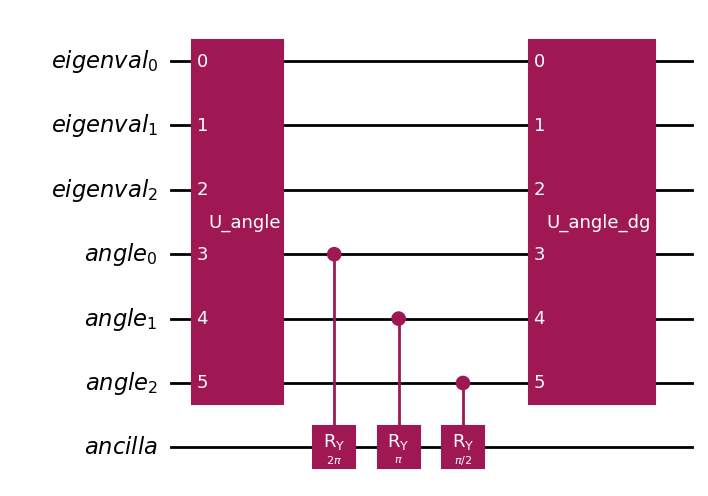

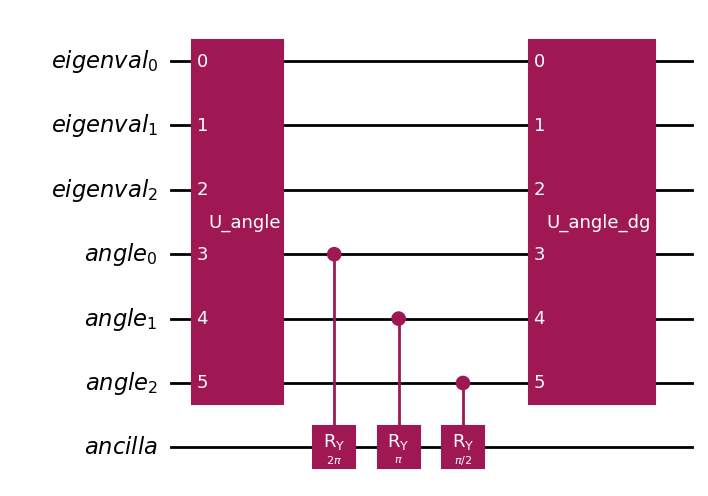

In [47]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RYGate
from numpy import pi

def construct_u_angle(d):
    """
    Placeholder U_angle gate: copies each eigenval qubit to angle qubit.
    In real HHL, this would compute theta_j = arcsin(C/lambda_j).
    """
    qc = QuantumCircuit(2*d, name="U_angle")
    for i in range(d):
        qc.cx(i, d+i)
    return qc.to_gate()

def controlled_rotation_subcircuit(d, theta_angles=None):
    """
    Constructs the controlled rotation block for arbitrary d:
      eigenval (|lambda_j⟩), angle (|tilde_theta_j⟩), ancilla (|0⟩)
    """
    eigenval = QuantumRegister(d, 'eigenval')
    angle = QuantumRegister(d, 'angle')
    ancilla = QuantumRegister(1, 'ancilla')
    qc = QuantumCircuit(eigenval, angle, ancilla, name="CtrlRotSub")

    # STEP 1: U_angle
    U_angle_gate = construct_u_angle(d)
    qc.append(U_angle_gate, eigenval[:] + angle[:])
    
    # STEP 2: Controlled Ry rotations
    if theta_angles is None:
        theta_angles = [pi/(2**i) for i in range(d)]
    for i in range(d):
        ry_gate = RYGate(2*theta_angles[i]).control(1)
        qc.append(ry_gate, [angle[i], ancilla[0]])

    # STEP 3: U_angle†
    qc.append(U_angle_gate.inverse(), eigenval[:] + angle[:])
    return qc

# Usage example (change d as needed):
d = 3  # Try with any integer d ≥ 1
subcircuit = controlled_rotation_subcircuit(d)
subcircuit.draw('mpl')


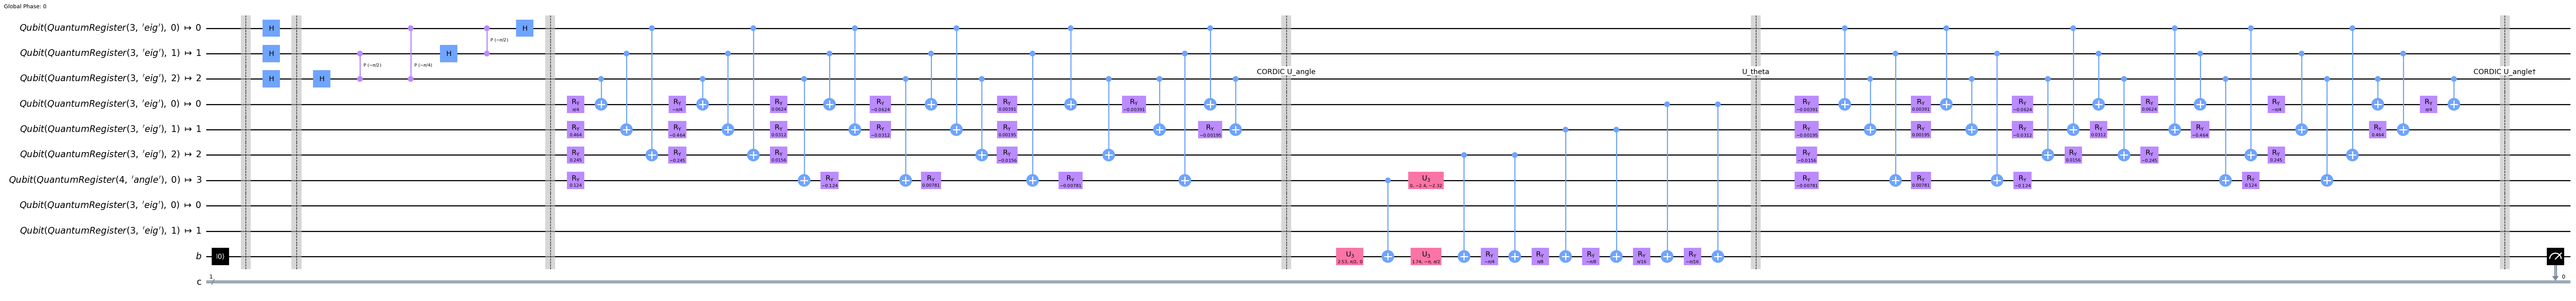


Quantum HHL CORDIC measurement counts: {'0': 1024}
Classical normalized solution: [ 0.9701425  -0.24253563]


In [ ]:
%matplotlib inline
import numpy as np
from math import pi, atan
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# Classical solution for comparison
def classical_solution(A, b):
    x = np.linalg.solve(A, b)
    return x / np.linalg.norm(x)

# Inverse QFT with Clifford+phase gates
def iqft_rotations(qc, qubits):
    n = len(qubits)
    for j in range(n // 2):
        qc.swap(qubits[j], qubits[n - j - 1])
    for j in range(n):
        qc.h(qubits[j])
        for k in range(j + 1, n):
            qc.cp(-pi / float(2 ** (k - j)), qubits[k], qubits[j])

# Quantum CORDIC iterative angle encoder routine
def quantum_cordic_arcsin(eigen, angle, ancilla, iterations=10):
    n_eig = len(eigen)
    n_ang = len(angle)
    qc = QuantumCircuit(eigen, angle, ancilla, name="CORDIC")
    cordic_angles = [atan(2 ** -i) for i in range(iterations)]
    for i in range(iterations):
        eig_idx = i % n_eig
        ang_idx = i % n_ang
        qc.cry(2 * cordic_angles[i], eigen[eig_idx], angle[ang_idx])
    return qc

# Full HHL circuit with CORDIC integration
def hhl_quantum_cordic(A, b, n_eig=3, n_angle=4, n_ancilla=2, cordic_iters=10):
    eig = QuantumRegister(n_eig, "eig")
    ang = QuantumRegister(n_angle, "angle")
    anc = QuantumRegister(n_ancilla, "anc")
    sol = QuantumRegister(1, "b")
    c = ClassicalRegister(1, "c")
    qc = QuantumCircuit(eig, ang, anc, sol, c)

    # Initialize solution register to |0>
    qc.initialize([1, 0], sol)
    qc.barrier()

    # Step 1: Mock phase estimation (Hadamards)
    qc.h(eig)
    qc.barrier()

    # Step 2: Inverse QFT
    iqft_rotations(qc, eig)
    qc.barrier()

    # Step 3: Quantum CORDIC angle encoder
    cordic_circuit = quantum_cordic_arcsin(eig, ang, anc, iterations=cordic_iters)
    qc.append(cordic_circuit.to_instruction(), eig[:] + ang[:] + anc[:])
    qc.barrier(label="CORDIC U_angle")

    # Step 4: Controlled RY rotations (singular value inversion)
    for i in range(n_angle):
        theta = pi / (2 ** i)
        qc.cry(theta, ang[n_angle - 1 - i], sol[0])
    qc.barrier(label="U_theta")



    # Step 5: Uncompute CORDIC
    qc.append(cordic_circuit.inverse().to_instruction(), eig[:] + ang[:] + anc[:])
    qc.barrier(label="CORDIC U_angle†")

    # Step 6: Measure solution qubit
    qc.measure(sol, c)
    return qc

if __name__ == "__main__":
    # Example: 2x2 system
    A = np.array([[1, 1/4], [1/4, 1]])
    b = np.array([1, 0])
    qc = hhl_quantum_cordic(A, b, n_eig=3, n_angle=4, n_ancilla=2, cordic_iters=10)
    
    # Decompose to Clifford/basis gates for Aer compatibility
    basis_gates = ['u3', 'cx', 'id', 'rz', 'sx', 'x', 'ry', 'cp', 'h', 'swap']
    basic_qc = transpile(qc, basis_gates=basis_gates, optimization_level=3)

    # Draw the Clifford-style circuit (matplotlib, full width)
    fig = basic_qc.draw('mpl', style='clifford', fold=-1)
    plt.show()

    # Simulate and compare
    sim = AerSimulator()
    result = sim.run(basic_qc, shots=1024).result()
    counts = result.get_counts()
    print("\nQuantum HHL CORDIC measurement counts:", counts)

    x_classical = classical_solution(A, b)
    print("Classical normalized solution:", x_classical)
